## 神经机器翻译
欢迎来到本周的第一份编程作业！

你将建立一个神经机器翻译（NMT）模型，以将人类可读的日期（"25th of June, 2009"）转换为机器可读的日期（"2009-06-25"）。 你将使用注意力模型来完成此任务，注意力模型是序列模型中最复杂的序列之一。

此笔记本是与NVIDIA深度学习研究所共同编写的。

让我们加载此作业所需的所有软件包。

In [3]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm_notebook as tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

ImportError: cannot import name 'Adam'

### 1 将人类可读的日期转换成机器可读的日期
你在此处构建的模型可用于将一种语言翻译成另一种语言，例如从英语翻译成印地语。但是，语言翻译需要大量的数据集，通常需要花费数天时间在GPU上进行训练。为了给你提供一个即使不使用大量数据集也可以试验这些模型的地方，我们将使用更简单的“日期转换”任务。

网络将以各种可能的格式输入日期（例如 "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"），并将其转换为标准化的机器可读日期（例如"1958-08-29", "1968-03-30", "1987-06-24"）。我们将让网络学习如何以通用的机器可读格式YYYY-MM-DD输出日期。

查看nmtutils.py以查看所有格式。计算并弄清楚格式如何工作，之后你将需要应用这些知识。

#### 1.1 数据集
我们将在10000个人类可读日期及其等效的标准化机器可读日期的数据集上训练模型。让我们运行以下单元格以加载数据集并打印一些示例。

In [4]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

NameError: name 'load_dataset' is not defined

In [5]:
dataset[:10]

NameError: name 'dataset' is not defined

[('9 may 1998', '1998-05-09'),
 
 ('10.11.19', '2019-11-10'),
 
 ('9/10/70', '1970-09-10'),
 
 ('saturday april 28 1990', '1990-04-28'),
 
 ('thursday january 26 1995', '1995-01-26'),
 
 ('monday march 7 1983', '1983-03-07'),
 
 ('sunday may 22 1988', '1988-05-22'),
 
 ('08 jul 2008', '2008-07-08'),
 
 ('8 sep 1999', '1999-09-08'),
 
 ('thursday january 1 1981', '1981-01-01')]


你已加载：

- dataset ：（人可读日期，机器可读日期）元组列表
- human_vocab：python字典，将人类可读日期中使用的所有字符映射到整数索引
- machine_vocab：python字典，将机器可读日期中使用的所有字符映射到整数索引。这些索引不一定与human_vocab一致。
- inv_machine_vocab：machine_vocab的逆字典，从索引映射回字符。

让我们预处理数据并将原始文本数据映射到索引值。我们还将使用Tx = 30（我们假设这是人类可读日期的最大长度；如果输入的时间更长，则必须截断它）和Ty = 10（因为“YYYY-MM-DD”为10个长字符）。



In [6]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

NameError: name 'preprocess_data' is not defined

X.shape: (10000, 30)

Y.shape: (10000, 10)

Xoh.shape: (10000, 30, 37)

Yoh.shape: (10000, 10, 11)

你现在拥有：

- X：训练集中人类可读日期的处理版本，其中每个字符都由通过human_vocab映射到该字符的索引替换。每个日期都用特殊字符（<pad>）进一步填充为Tx值。X.shape = (m, Tx)
- Y：训练集中机器可读日期的处理版本，其中每个字符都被映射为machine_vocab中映射到的索引替换。你应该具有Y.shape = (m, Ty)。
- Xoh：X的一个独热版本，由于human_vocab，将“1”条目的索引映射到该字符。Xoh.shape = (m, Tx, len(human_vocab))
- Yoh：Y的一个独热版本，由于使用machine_vocab，因此将“1”条目的索引映射到了该字符。Yoh.shape = (m, Tx, len(machine_vocab))在这里，因为有11个字符（“-”以及0-9），所以len(machine_vocab) = 11。

我们再看一些预处理训练集的示例。你可以在下面的单元格中随意使用index来查看数据集，并查看如何对source/target日期进行预处理。

In [7]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

NameError: name 'dataset' is not defined

**理想效果**：

Source date: 9 may 1998

Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]

Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]

Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### 2 带注意力机制的神经机器翻译
如果你必须将一本书的段落从法语翻译为英语，则无需阅读整个段落然后关闭该书并进行翻译。即使在翻译过程中，你也会阅读/重新阅读并专注于与你所写下的英语部分相对应的法语段落部分。

注意机制告诉神经机器翻译模型在任何步骤都应该注意到的地方。
- 我：一个讲注意力机制讲的不错的[文章](http://t.csdn.cn/6X1RE)

#### 2.1 注意力机制

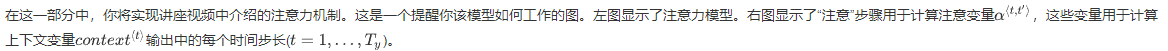

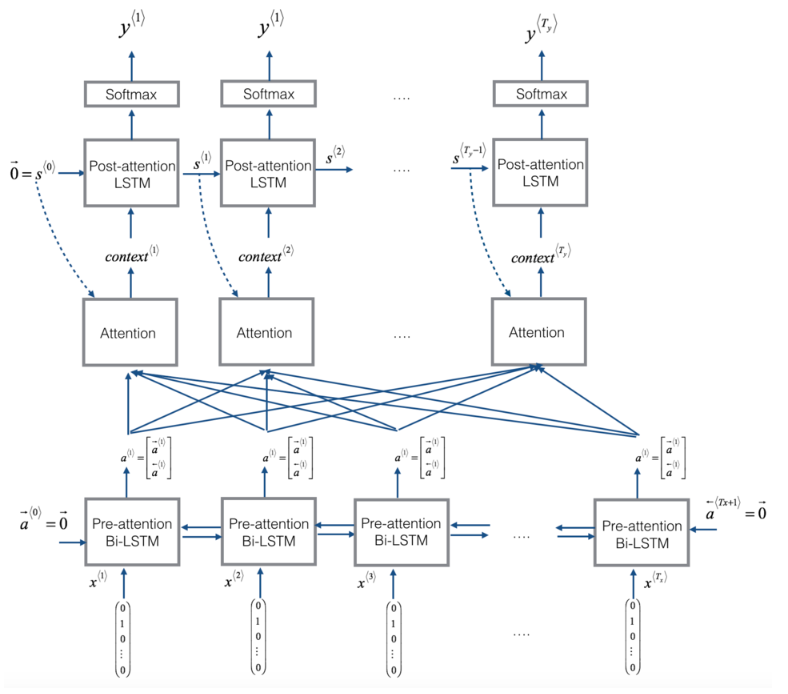

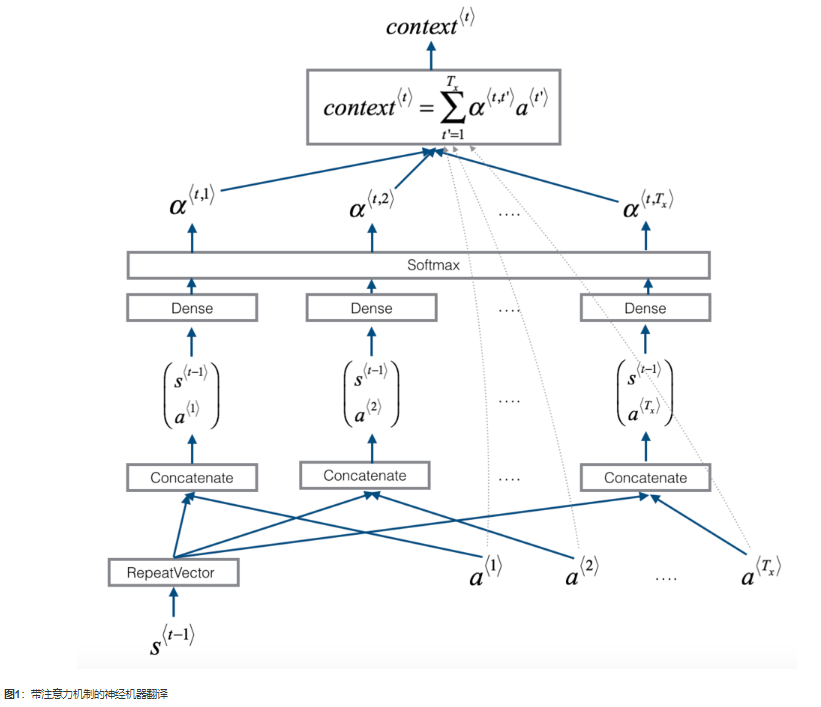

你可能会注意到以下一些模型属性：
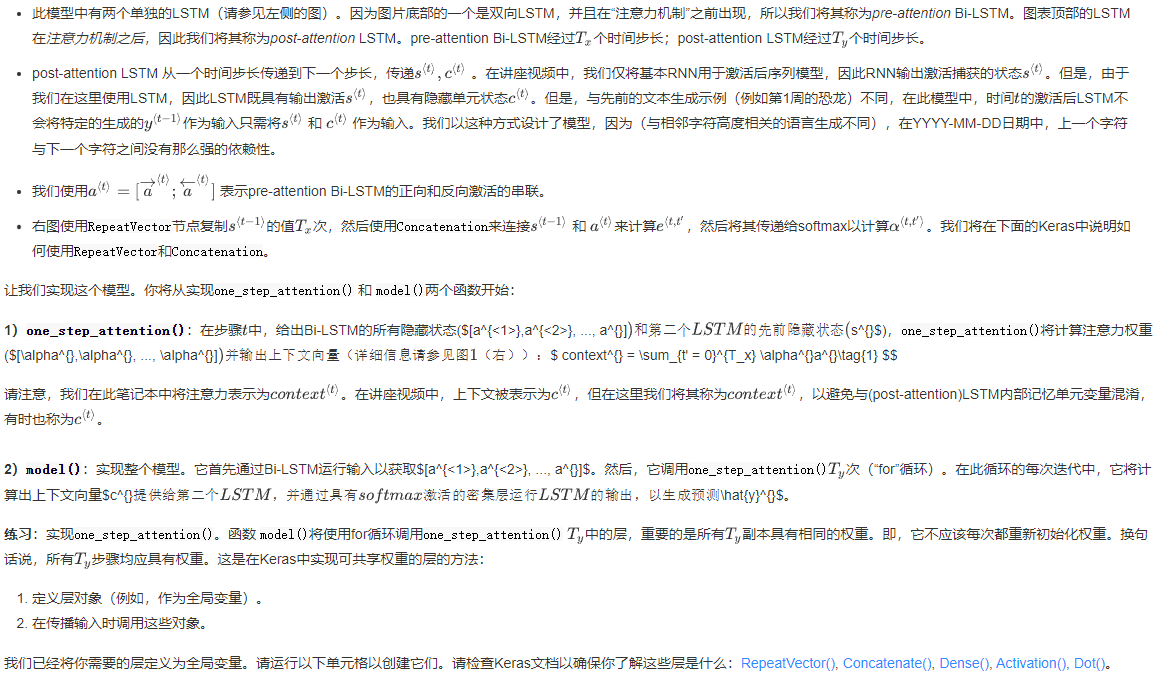

In [8]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

NameError: name 'softmax' is not defined

现在你可以使用这些层来实现one_step_attention()。 为了通过这些层之一传播Keras张量对象X，请使用layer（X）（如果需要多个输入则使用layer（[X，Y]））。densor(X)将通过上面定义的 Dense(1) 层传播X。

In [9]:
# GRADED FUNCTION: one_step_attention

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    ### START CODE HERE ###
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas,a])
    ### END CODE HERE ###
    
    return context

在对model()函数进行编码之后，你将能够检查one_step_attention()的预期输出。

**练习**：按照图2和上面的文字中的说明实现model()。再次，我们定义了全局层，这些全局层将共享将在model()中使用的权重。

In [10]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

NameError: name 'machine_vocab' is not defined

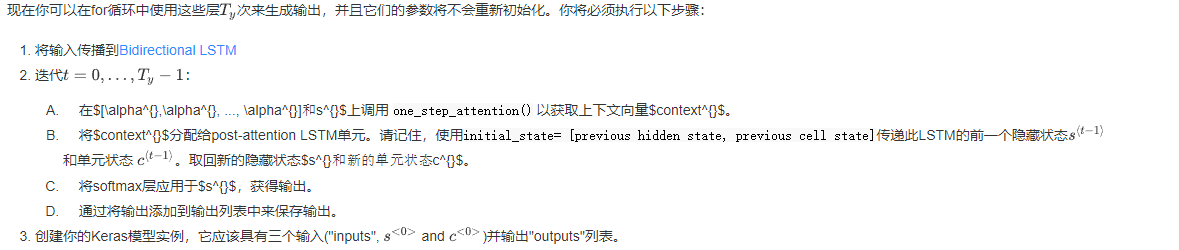

In [11]:
# GRADED FUNCTION: model

def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    ### START CODE HERE ###
    
    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a,s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s,c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=[X, s0, c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

运行以下单元格以创建模型。

In [13]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

NameError: name 'human_vocab' is not defined

让我们获得模型的总结，以检查其是否与预期输出匹配。

In [14]:
model.summary()

AttributeError: 'function' object has no attribute 'summary'

**预期输出**:

Here is the summary you should see

| Total params: | 185,484 |

| ------------------------------------- | --------------- |

| Trainable params: | 185,484 |

| Non-trainable params: | 0 |

| bidirectional_1's output shape | (None, 30, 128) |

| repeat_vector_1's output shape | (None, 30, 128) |

| concatenate_1's output shape | (None, 30, 256) |

| attention_weights's output shape | (None, 30, 1) |

| dot_1's output shape | (None, 1, 128) |

| dense_2's output shape | (None, 11) |

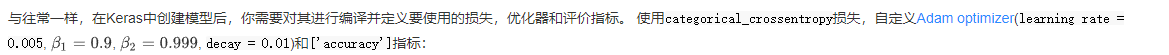

In [15]:
### START CODE HERE ### (≈2 lines)
opt = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
### END CODE HERE ###

NameError: name 'Adam' is not defined

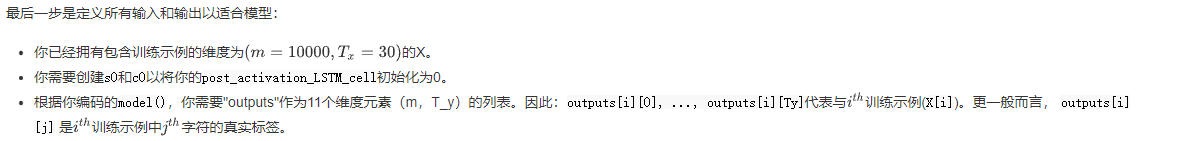

In [16]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

NameError: name 'np' is not defined

现在让我们拟合模型并运行一个epoch。

In [17]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

AttributeError: 'function' object has no attribute 'fit'

训练时，你可以看到输出的10个位置中的每个位置的损失以及准确性。下表为你提供了一个示例，说明该批次有2个示例时的精确度：

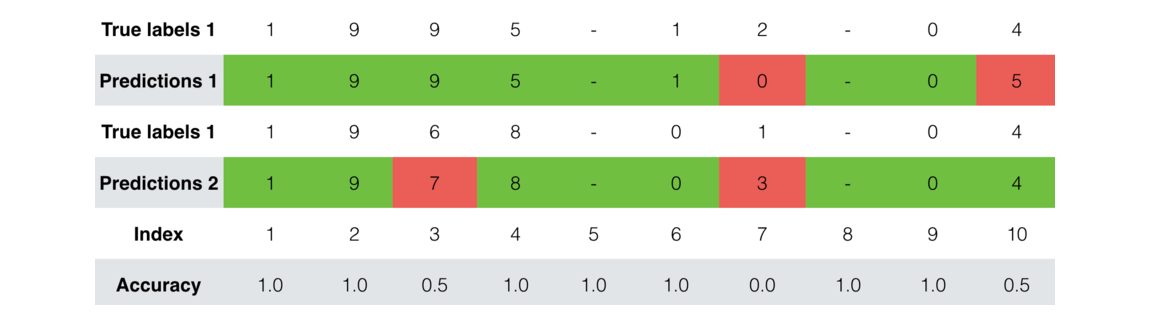

因此，dense_2_acc_8: 0.89意味着你在当前数据批次中有89％的时间正确预测了输出的第7个字符。

我们对该模型运行了更长的时间，并节省了权重。运行下一个单元格以加载我们的体重。（通过训练模型几分钟，你应该可以获得准确度相似的模型，但是加载我们的模型可以节省你的时间。）

In [18]:
model.load_weights('models/model.h5')

AttributeError: 'function' object has no attribute 'load_weights'

现在，你可以在新示例中查看结果。

In [19]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source)))
    prediction = model.predict([[source], s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

NameError: name 'string_to_int' is not defined

source: 3 May 1979

output: 1979-05-03

source: 5 April 09

output: 2009-05-05

source: 21th of August 2016

output: 2016-08-21

source: Tue 10 Jul 2007

output: 2007-07-10

source: Saturday May 9 2018

output: 2018-05-09

source: March 3 2001

output: 2001-03-03

source: March 3rd 2001

output: 2001-03-03

source: 1 March 2001

output: 2001-03-01

你也可以更改这些示例，以使用自己的示例进行测试。下一部分将使你更好地了解注意力机制的作用-即生成特定输出字符时网络要注意的输入部分。

### 3 可视化注意力（可选练习）
略